# **Laboratory Lecture 3**

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes:
- `expand` to generate successors;
- `path_actions` and `path_states` to recover aspects of the path from the node.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding "actions" and "results", and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify "initial", and "goal" states
    (or give an "is_goal" method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds):
        """Default constructor for the Problem class."""
        # il self.__dict__ è il dizionario dove vengono salvate tutte le variabili dell'istanza della classe
        # self.__dict__.update(initial=initial, goal=goal, **kwds) <--> self.initial=initial, self.goal=goal, ...
        # **kwds sono qualsiasi altri attributi che vengono passati come parametri della funzione
        self.__dict__.update(initial=initial, goal=goal, **kwds)

    def actions(self, state):
        """Lists all the actions from the node specified as parameter."""
        raise NotImplementedError

    def result(self, state, action):
        """Returns the result of the action applied to the state specified as parameter."""
        raise NotImplementedError

    def is_goal(self, state):
        """Verify if the specified state correspond to the goal."""
        return state == self.goal

    def action_cost(self, s, a, s1):
        """Compute the action cost of the action a from state s to state s1."""
        return 1

    def h(self, node):
        """Heuristic function for the node specified as parameter."""
        return 0

    def __str__(self):
        """Overloading of str()."""
        return "{}({!r}, {!r})".format(type(self).__name__, self.initial, self.goal)


class Node:
    """A Node in a search tree."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Default costructor:
        - state: state associated to this node;
        - parent: parent node of this node (None for the root node);
        - action: action applied to the parent node to reach this node;
        - path_cost: depth of this node (distance from the root)."""
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self):
        """Overloading of repr()."""
        return "<{}>".format(self.state)

    def __len__(self):
        """Node depth from the root."""
        return 0 if self.parent is None else (1 + len(self.parent))

    def __lt__(self, other):
        """True if the first node has path_cost."""
        return self.path_cost < other.path_cost


failure = Node("failure", path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
"""The algorithm couldn't find a solution."""

cutoff  = Node("cutoff",  path_cost=math.inf) # Indicates iterative deepening search was cut off.
"""Iterative deepening search was cut off."""


def expand(problem, node):
    """Expand a node, generating the children nodes."""
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)

        # yield restituisce un nodo per volta ad ogni successiva invocazione della funzione e permette di
        # iterare sui valori restituiti dalla funzione: "for child in expand(problem, node): ... "
        # in qualche modo accumula tutti i valori da restituire in una coda e restituisce la coda iterabile
        # alla fine di tutta la funzione
        yield Node(s1, node, action, cost)

def path_actions(node):
    """Return the actions made to reach this node."""
    if node.parent is None: return []
    return path_actions(node.parent) + [node.action] # mettendo le "[]" si specifica che il "+" è una concatenazione di liste

def path_states(node):
    """Return the states visited to reach this node."""
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state] # mettendo le "[]" si specifica che il "+" è una concatenazione di liste

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [21]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        """Default constructor:
        - items: tuple with items to insert in the queue;
        - key: lambda for calculating priority"""
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self):
        """Return the item with min f(item) value, without removing it."""
        return self.items[0][1]

    def __len__(self):
        """Return the number of elements in the queue."""
        return len(self.items)

# Search Algorithms based on Best-First-Search

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

### List of algorithms:
| algorithm | description |
| :- | :- |
| `best_first_search(p, f)` | generic search algorithm, the next node to visit has lowest `f` score |
| `best_first_tree_search(p, f)` | generic seach algorithm using a tree search, the next node to visit has the lowest `f` score |
| `astar_search(p, h)` | A* search algorithm with `h` heuristic function (optional) |
| `astar_tree_search(p, h)` | A* search algorithm using a tree search with `h` heuristic function (optional) |
| `weighted_astar_search(p, h, weight)` | WA* search algorithm with `h` heuristic function (optional) and `weight` (optional)  |
| `greedy_bfs(p, h)` | greedy search algorithm with `h` heuristic function (optional) |
| `uniform_cost_search(p)` | uniform cost or Dijkstra algorithm |
| `breadth_first_bfs(p)` | breadth first search algorithm implemented using best_first_search with `f=len` |
| `depth_first_bfs(p)` | depth first search algorithm implemented using best_first_search with `f=-len` |

In [22]:
def best_first_search(problem, f):
    """Search nodes with minimum f(node) value first and return the goal node or the failure node"""
    # NOTES:
    # - "reached" dictionary is used to check if a new node creates cycles before putting it inside the frontier
    # - goal_reachness check is done only on visited nodes -> nodes have the best path_cost only when they are
    #   extracted from the frontier and then visited

    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}

    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def best_first_tree_search(problem, f):
    """A version of best_first_search without the "reached" table."""
    # NOTES:
    # - the only difference with the bfs using "reached" dictionary is the method used to verify if a new node creates
    #   cycles -> this algorithm uses the is_cycle(child) method, instead of checking if it is already reached

    frontier = PriorityQueue([Node(problem.initial)], key=f)

    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure

def g(n):
    """Function that returns the path_cost of a node"""
    return n.path_cost

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no "reached" table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))

def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

def uniform_cost_search(problem):
    """Search nodes with minimum path cost first."""
    return best_first_search(problem, f=g)

def breadth_first_bfs(problem):
    """Search shallowest nodes in the search tree first; using best-first."""
    return best_first_search(problem, f=len)

def depth_first_bfs(problem):
    """Search deepest nodes in the search tree first; using best-first."""
    return best_first_search(problem, f=lambda n: -len(n))

def is_cycle(node, k=30):
    """Does this node form a cycle of length k or less?"""
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)


# Other Search Algorithms

Here are the other search algorithms:

| algorithm | description |
| :- | :- |
| `breadth_first_search(p)` | breadth first search using FIFO queue |
| `iterative_deepening_search(p)` | execute the depth_limited_search incrementing the depth limit|
| `depth_limited_search(p, l)` | depth first search using LIFO stack with `l` maximum depth limit (optional) |
| `depth_first_recursive_search(p, n)` | recursive implementation of depth first search with `n` as starting node (optional) |

In [23]:
def breadth_first_search(problem):
    """Search shallowest nodes in the search tree first."""
    # NOTES:
    # - goal_reachness check is done before adding nodes in the frontier, this is slightly more efficient than
    #   the corresponding breadth_first_search implemented via best_first_search with f=len(node)

    node = Node(problem.initial)

    if problem.is_goal(problem.initial):
        return node

    frontier = FIFOQueue([node])
    reached = {problem.initial}

    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
                #print(frontier)
    return failure

def iterative_deepening_search(problem):
    """Do depth-limited search with increasing depth limits."""
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result

def depth_limited_search(problem, limit=10):
    """Search deepest nodes in the search tree first."""
    # NOTES:
    # - goal_reachness check is done only on visited nodes, like other best_first_search algorithms

    frontier = LIFOQueue([Node(problem.initial)])
    result = failure

    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result

def depth_first_recursive_search(problem, node=None):
    """Search deepest nodes in the search tree first using recursive depth-first."""
    # NOTES:
    # - goal_reachness check is done only on visited nodes, like other best_first_search algorithms
    # - in python the "if obj" statement returns true if:
    #   - obj != None, False, 0, "", [], (), {}
    #   - obj.__bool__() == true if the class overrides the __bool__() method
    #   - obj.__len__() != 0 if the class overrides the __len__() method and doesn't override __bool__() method
    #   - always if the class does not override neither __bool__() or __len__() method
    #   the "result" variable is a Node object that overrides the __len__() method => the "if result" statement returns
    #   false if result == root, failure or cutoff because those three nodes have len() == 0

    if node is None:
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result: # returns true if result is a valid node != root, failure or cutoff  ->  * check notes
                return result
        return failure

# Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

# Route Finding Problems

<img src="https://drive.google.com/uc?id=1cSyp7BPPtjRqbS8vF77XQmxbro4fPogG">

In a `RouteProblem`, the states are names of "cities" (or other locations), like `"A"` for Arad. The actions are also city names; `"Z"` is the action to move to city `"Z"`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.

In [24]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a "Map".
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    # NOTES:
    # - RouteProblem class requires a map parameter, when creating new RouteProblem object you need to specify
    # the map attribute with the associated map -> for Romania Problem: RouteProblem("A","B",map=romania)

    def actions(self, state):
        """The places neighboring "state"."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the "action" place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        """Straight-line distance between state and the goal."""
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])


def straight_line_distance(A, B):
    """Straight-line distance between two points."""
    # zip function generates a list of pairs with one element of A and one element of B:
    # example A = (1,2,3,4,5), B = (6,7,8,9) ==> zip(A,B) -> [(1,6), (2,7), (3,8), (4,9)]
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [25]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In "Map(links, locations)":
    - "links" can be either [(v1, v2)...] pairs, or a {(v1, v2): distance...} dict
    - "locations" (optional) can be {v1: (x, y)}
    - if "directed = False" then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        """Costructor for Map class:
        - links: connections between nodes ("[(v1, v2)...]" pairs or "{(v1, v2): distance...}" dicts);
        - locations (optional): dictionary of node: (x, y)
        - directed: boolean thats states if graph is directed or undirected"""

        # if links is a simple list of unloaded connection, then it is transformed in a dictionary {connection: load}
        # with default load = 1
        if not hasattr(links, "items"):
            links = {link: 1 for link in links}

        # if graph is undirected, every connection is duplicated and reversed because every link can be used in
        # both directions
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]

        # save connections between nodes and their distances
        self.distances = links

        # compute a dictionary {node: [adjacent nodes]}
        self.neighbors = multimap(links)

        # save coordinates of every node, if they are not given, use (0,0) by default
        self.locations = locations or defaultdict(lambda: (0, 0))


def multimap(pairs) -> dict:
    """Given (key, val) pairs, make a dict of {key: [val,...]}."""
    # convert a pair list (or dict) in a dictionary that links every node (key) with a list of its adjacent nodes (value)
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [26]:
# Some specific RouteProblems based on Romania Problem
romania = Map(
    # links between cities with thier weigth
    {("O", "Z"):  71, ("O", "S"): 151, ("A", "Z"): 75, ("A", "S"): 140, ("A", "T"): 118,
     ("L", "T"): 111, ("L", "M"):  70, ("D", "M"): 75, ("C", "D"): 120, ("C", "R"): 146,
     ("C", "P"): 138, ("R", "S"):  80, ("F", "S"): 99, ("B", "F"): 211, ("B", "P"): 101,
     ("B", "G"):  90, ("B", "U"):  85, ("H", "U"): 98, ("E", "H"):  86, ("U", "V"): 142,
     ("I", "V"):  92, ("I", "N"):  87, ("P", "R"): 97},
    # cities and coordinates:
    # coordinates are used to compute the understimate distance in the heuristic function
    {"A": ( 76, 497), "B": (400, 327), "C": (246, 285), "D": (160, 296), "E": (558, 294),
     "F": (285, 460), "G": (368, 257), "H": (548, 355), "I": (488, 535), "L": (162, 379),
     "M": (160, 343), "N": (407, 561), "O": (117, 580), "P": (311, 372), "R": (227, 412),
     "S": (187, 463), "T": ( 83, 414), "U": (471, 363), "V": (535, 473), "Z": (92, 539)})

# defining problems using the "romania" Map
r0 = RouteProblem("A", "A", map=romania)
r1 = RouteProblem("A", "B", map=romania)
r2 = RouteProblem("N", "L", map=romania)
r3 = RouteProblem("E", "T", map=romania)
r4 = RouteProblem("O", "M", map=romania)

In [27]:
# Solutions of Romania problems using uniform_cost_search (Dijkstra): lowest path cost
print("Arad to Arad:         " + str(path_states(uniform_cost_search(r0)))) # path from Arad to Arad
print("Arad to Bucharest:    " + str(path_states(uniform_cost_search(r1)))) # path from Arad to Bucharest
print("Neamt to Lugoj:       " + str(path_states(uniform_cost_search(r2)))) # path from Neamt to Lugoj
print("Eforie to Timisioara: " + str(path_states(uniform_cost_search(r3)))) # path from Eforie to Timisioara
print("Oradea to Mehadia:    " + str(path_states(uniform_cost_search(r4)))) # path from Oradea to Mehadia

Arad to Arad:         ['A']
Arad to Bucharest:    ['A', 'S', 'R', 'P', 'B']
Neamt to Lugoj:       ['N', 'I', 'V', 'U', 'B', 'P', 'C', 'D', 'M', 'L']
Eforie to Timisioara: ['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']
Oradea to Mehadia:    ['O', 'Z', 'A', 'T', 'L', 'M']


In [28]:
# Solutions of Romania problems using breadth_first_search: fewer steps, higher path cost
print("Arad to Arad:         " + str(path_states(breadth_first_search(r0)))) # path from Arad to Arad
print("Arad to Bucharest:    " + str(path_states(breadth_first_search(r1)))) # path from Arad to Bucharest
print("Neamt to Lugoj:       " + str(path_states(breadth_first_search(r2)))) # path from Neamt to Lugoj
print("Eforie to Timisioara: " + str(path_states(breadth_first_search(r3)))) # path from Eforie to Timisioara
print("Oradea to Mehadia:    " + str(path_states(breadth_first_search(r4)))) # path from Oradea to Mehadia

Arad to Arad:         ['A']
Arad to Bucharest:    ['A', 'S', 'F', 'B']
Neamt to Lugoj:       ['N', 'I', 'V', 'U', 'B', 'F', 'S', 'A', 'T', 'L']
Eforie to Timisioara: ['E', 'H', 'U', 'B', 'F', 'S', 'A', 'T']
Oradea to Mehadia:    ['O', 'Z', 'A', 'T', 'L', 'M']


# Pancake Sorting Problems

Given a stack of pancakes of various sizes, can you sort them into a stack of decreasing sizes, largest on bottom to smallest on top? You have a spatula with which you can flip the top `i` pancakes. This is shown below for `i = 3`; on the top the spatula grabs the first three pancakes; on the bottom we see them flipped:


![](https://upload.wikimedia.org/wikipedia/commons/0/0f/Pancake_sort_operation.png)

How many flips will it take to get the whole stack sorted? This is an interesting [problem](https://en.wikipedia.org/wiki/Pancake_sorting) that Bill Gates has [written about](https://people.eecs.berkeley.edu/~christos/papers/Bounds%20For%20Sorting%20By%20Prefix%20Reversal.pdf). A reasonable heuristic for this problem is the *gap heuristic*: if we look at neighboring pancakes, if, say, the 2nd smallest is next to the 3rd smallest, that's good; they should stay next to each other. But if the 2nd smallest is next to the 4th smallest, that's bad: we will require at least one move to separate them and insert the 3rd smallest between them. The gap heuristic counts the number of neighbors that have a gap like this. In our specification of the problem, pancakes are ranked by size: the smallest is `1`, the 2nd smallest `2`, and so on, and the representation of a state is a tuple of these rankings, from the top to the bottom pancake. Thus the goal state is always `(1, 2, ..., "n")` and the initial (top) state in the diagram above is `(2, 1, 4, 6, 3, 5)`.


In [29]:
class PancakeProblem(Problem):
    """A PancakeProblem the goal is always "tuple(range(1, n+1))", where the
    initial state is a permutation of "range(1, n+1)". An act is the index "i"
    of the top "i" pancakes that will be flipped."""

    def __init__(self, initial):
        """Constuctor that receive only the initial state, the goal is calculated by sorting the initial state"""
        super().__init__(tuple(initial), tuple(sorted(initial)))

    def actions(self, state):
        """Return a list of actions: numbers of the pancakes where the spatula can be put under"""
        # NOTES:
        # return a number between 2 and the number of pancakes (state length)
        # - 0 -> spatula over the top of the stack -> turning nothing -> unuseful
        # - 1 -> spatula under the first pancake -> turning only the first pancake -> unuseful
        # - len(state)+1 -> because range(a,b) means [a,b) -> b is not included
        return range(2, len(state) + 1)

    def result(self, state, i):
        """State reached by flipping pancakes"""
        # state[:i] -> extract the first i elements of the list
        # ...[::-1] -> reverse the elements in the list
        # + state[i:] -> add the elements from index i to the end of the list
        return state[:i][::-1] + state[i:]

    def h(self, node):
        """The gap heuristic."""
        s = node.state
        # count all the adjacent pancake pairs with size difference > 1
        return sum(abs(s[i] - s[i - 1]) > 1 for i in range(1, len(s)))

In [30]:
# defining some problems with different initial states
c0 = PancakeProblem((2, 1, 4, 6, 3, 5))
c1 = PancakeProblem((4, 6, 2, 5, 1, 3))
c2 = PancakeProblem((1, 3, 7, 5, 2, 6, 4))
c3 = PancakeProblem((1, 7, 2, 6, 3, 5, 4))
c4 = PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 8))

In [31]:
# solve a pancake problem
print(path_states(astar_search(c0)))
print(path_actions(astar_search(c0)))

[(2, 1, 4, 6, 3, 5), (6, 4, 1, 2, 3, 5), (5, 3, 2, 1, 4, 6), (4, 1, 2, 3, 5, 6), (3, 2, 1, 4, 5, 6), (1, 2, 3, 4, 5, 6)]
[4, 6, 5, 4, 3]


# Reporting Summary Statistics on Search Algorithms

Now let's gather some metrics on how well each algorithm does.  We'll use `CountCalls` to wrap a `Problem` object in such a way that calls to its methods are delegated to the original problem, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [32]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

In [33]:
# defining algorithms for Romania problem
algorithms = [uniform_cost_search, breadth_first_bfs, breadth_first_search, depth_first_bfs, depth_limited_search, depth_first_recursive_search, iterative_deepening_search, astar_search, astar_tree_search, weighted_astar_search, greedy_bfs]

# defining instances of Romania problem
problems = [r0, r1, r2, r3, r4]

# generating report
report(algorithms, problems, True)

uniform_cost_search:
        0 nodes |        1 goal |    0 cost |       0 actions | RouteProblem('A', 'A')
       30 nodes |       13 goal |  418 cost |      16 actions | RouteProblem('A', 'B')
       42 nodes |       19 goal |  910 cost |      27 actions | RouteProblem('N', 'L')
       44 nodes |       20 goal |  805 cost |      27 actions | RouteProblem('E', 'T')
       30 nodes |       12 goal |  445 cost |      16 actions | RouteProblem('O', 'M')
      146 nodes |       65 goal | 2578 cost |      86 actions | TOTAL

breadth_first_bfs:
        0 nodes |        1 goal |    0 cost |       0 actions | RouteProblem('A', 'A')
       28 nodes |       12 goal |  450 cost |      14 actions | RouteProblem('A', 'B')
       55 nodes |       24 goal |  910 cost |      32 actions | RouteProblem('N', 'L')
       51 nodes |       22 goal |  837 cost |      28 actions | RouteProblem('E', 'T')
       40 nodes |       16 goal |  445 cost |      20 actions | RouteProblem('O', 'M')
      174 nodes |  

# Analisi degli algoritmi di ricerca ed esericizi del quiz Lab3

In [34]:
# redefining report() and report_counts to print path_states and path_actions
def report_custom(searchers, problem):
    """Show summary statistics for each searcher."""
    for searcher in searchers:
        prob   = CountCalls(problem)
        soln   = searcher(prob)
        counts = prob._counts;
        counts.update(actions=len(soln), cost=soln.path_cost)
        report_counts_custom(searcher.__name__, counts, soln, problem)

def report_counts_custom(algorithm, counts, result, problem):
    """Print one line of the counts report."""
    print("{:30} |{:5,d} nodes |{:5,d} is_goal |{:5.0f} cost |{:5,d} actions | states: {:40} | actions: {} ".format(algorithm, counts["result"], counts["is_goal"], counts["cost"], counts["actions"], str(path_states(result)), path_actions_custom(problem, result)))

def print_barplot(searchers, problems):
    """Prints a bar plot per each metric"""
    # NOTES:
    # - main variables used:
    #   - counters: list that saves all the counts objects of each searcher
    #   - searcher_counts: cumulative count for all the problems solved by one specific searcher
    #   - sol_counts: counts of a specific solution (problem - searcher)
    # - every counter is composed by:
    #   - "result": nodes visited
    #   - "is_goal": goal check made
    #   - "actions": number of actions made
    #   - "cost": path cost of the solution
    # - algorithm:
    #   part1
    #     iterates on every searcher:
    #     | iterates on every problem:
    #     | | calculate the counter the solution (problem, searcher)
    #     | | add the solution counts to the searcher count
    #     | append the searcher count in the counters list
    #   part2
    #     generate all the required bar plots

    # calculating counters
    counters = []
    for searcher in searchers:
        searcher_counts = Counter()
        for problem in problems:
            prob   = CountCalls(problem)
            soln   = searcher(prob)
            sol_counts = prob._counts;
            sol_counts.update(actions=len(soln), cost=soln.path_cost)
            searcher_counts += sol_counts
        counters.append(searcher_counts)

    # generating plot for visited nodes
    plt.bar(range(len(searchers)), [counter["result"] for counter in counters])
    plt.xticks(range(len(searchers)), [searcher.__name__ for searcher in searchers], rotation=90)
    plt.title("Number of nodes visited")
    plt.show()

    # generating plot for is_goal checks
    plt.bar(range(len(searchers)), [counter["is_goal"] for counter in counters])
    plt.xticks(range(len(searchers)), [searcher.__name__ for searcher in searchers], rotation=90)
    plt.title("Number of goal checks")
    plt.show()

    # generating plot for actions done
    plt.bar(range(len(searchers)), [counter["actions"] for counter in counters])
    plt.xticks(range(len(searchers)), [searcher.__name__ for searcher in searchers], rotation=90)
    plt.title("Actions done")
    plt.show()

    # generating plot for solution cost
    plt.bar(range(len(searchers)), [counter["cost"] for counter in counters])
    plt.xticks(range(len(searchers)), [searcher.__name__ for searcher in searchers], rotation=90)
    plt.title("Solution cost")
    plt.show()

# generating list of tuples  with relative cost
def path_actions_custom(problem, node):
    """Return the actions and their cost made to reach this node."""
    if node.parent is None: return []
    return path_actions_custom(problem, node.parent) + [(node.action,problem.action_cost(node.parent.state,node.action,node.state))]


In [35]:
# defining algorithms for Romania problem
algorithms_for_romania_problem = [uniform_cost_search,
              breadth_first_bfs,
              breadth_first_search,
              depth_first_bfs,
              depth_limited_search,
              depth_first_recursive_search,
              iterative_deepening_search,
              astar_search,
              astar_tree_search,
              weighted_astar_search,
              greedy_bfs]

# definig algorithms for Pancake sorting
algorithms_for_pancake_sorting = [uniform_cost_search,
              breadth_first_bfs,
              breadth_first_search,
              depth_first_bfs,
              depth_limited_search,
              #depth_first_recursive_search, # RecursionError: maximum recursion depth exceeded
              iterative_deepening_search,
              astar_search,
              astar_tree_search,
              weighted_astar_search,
              greedy_bfs]

# printing report for Romania Problem from Arad to Bucharest
print("----- ROMANIA PROBLEM from ARAD to BUCHAREST -----")
report_custom(algorithms_for_romania_problem, r1)

print("\n\n----- PANCAKE PROBLEM for (2, 1, 4, 6, 3, 5) -----")
report_custom(algorithms_for_pancake_sorting, c0)

----- ROMANIA PROBLEM from ARAD to BUCHAREST -----
uniform_cost_search            |   30 nodes |   13 is_goal |  418 cost |   16 actions | states: ['A', 'S', 'R', 'P', 'B']                | actions: [('S', 140), ('R', 80), ('P', 97), ('B', 101)] 
breadth_first_bfs              |   28 nodes |   12 is_goal |  450 cost |   14 actions | states: ['A', 'S', 'F', 'B']                     | actions: [('S', 140), ('F', 99), ('B', 211)] 
breadth_first_search           |   18 nodes |   19 is_goal |  450 cost |   10 actions | states: ['A', 'S', 'F', 'B']                     | actions: [('S', 140), ('F', 99), ('B', 211)] 
depth_first_bfs                |   21 nodes |   10 is_goal |  733 cost |   16 actions | states: ['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B'] | actions: [('T', 118), ('L', 111), ('M', 70), ('D', 75), ('C', 120), ('P', 138), ('B', 101)] 
depth_limited_search           |   17 nodes |    8 is_goal |  733 cost |   14 actions | states: ['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B'] | actions: [('

In [36]:
# Exercise 1: Apply the function uniform_cost_search on r1. What is the cost?
print("solution for problem r1 using uniform_cost_search:")
report([uniform_cost_search], [r1], True)
print("path_states:  {}".format(path_states(uniform_cost_search(r1))))
print("path_actions: {}".format(path_actions_custom(r1,uniform_cost_search(r1))))

solution for problem r1 using uniform_cost_search:
uniform_cost_search:
       30 nodes |       13 goal |  418 cost |      16 actions | RouteProblem('A', 'B')
       30 nodes |       13 goal |  418 cost |      16 actions | TOTAL

path_states:  ['A', 'S', 'R', 'P', 'B']
path_actions: [('S', 140), ('R', 80), ('P', 97), ('B', 101)]


In [37]:
# Exercise 2: apply the function breadth_first_search on c2. What is the number of actions required to solve the problem?
print("solution for problem c2 using breadth_first_search:")
report([breadth_first_search],[c2],True)

solution for problem c2 using breadth_first_search:
breadth_first_search:
   25,945 nodes |   25,946 goal |    8 cost |   4,333 actions | PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1
   25,945 nodes |   25,946 goal |    8 cost |   4,333 actions | TOTAL



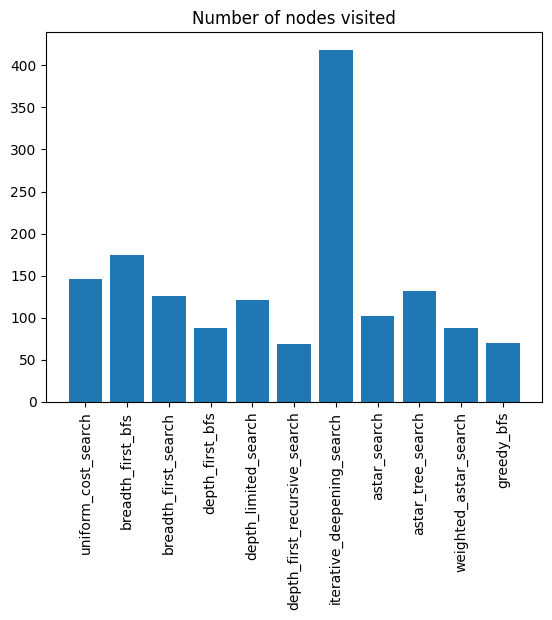

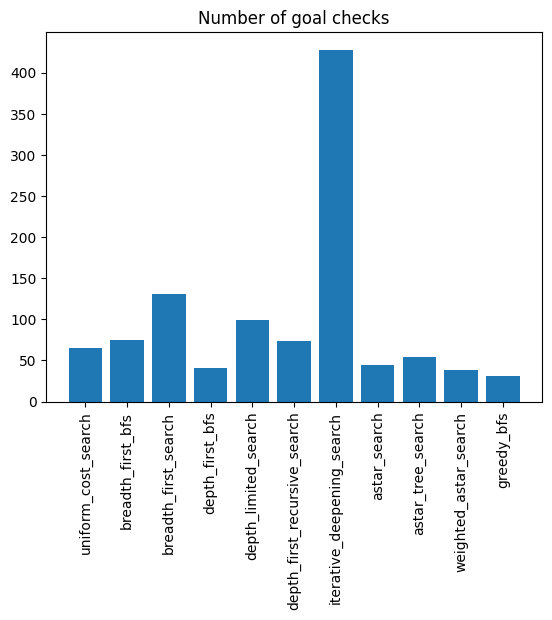

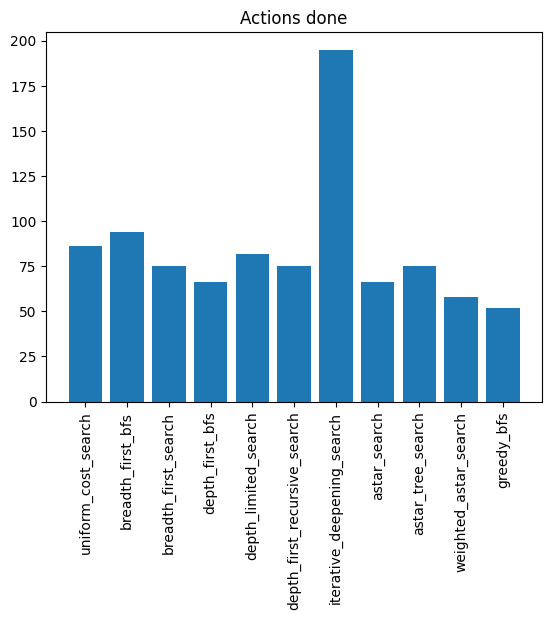

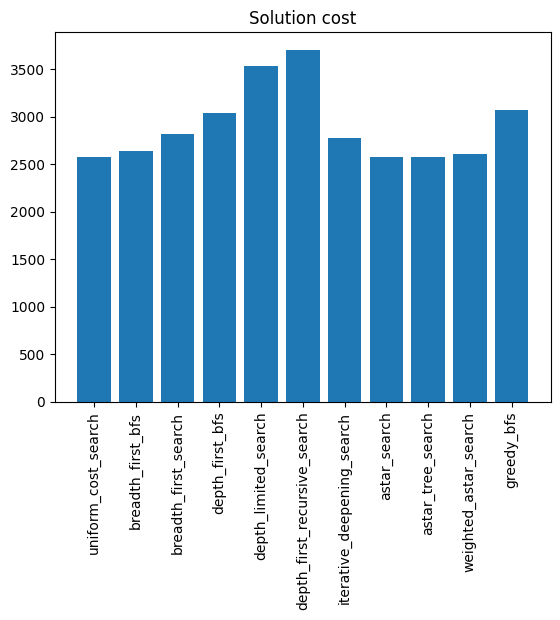

In [38]:
# Exercise 3: plot the results using a bar plot per each metric and per each problem to better compare the different search algorithms.
print_barplot(algorithms_for_romania_problem, [r0,r1,r2,r3,r4])